In [1]:
import os
import time
from datetime import timedelta
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torchvision.datasets import MNIST
from torchvision import datasets, transforms, utils
import math

In [2]:
# device = 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print ("Using device: %s (version %s)" % (device, torch.version.cuda if device=='cuda' else 'N/A'))
print("Using CuDNN: %s\n" % (torch.backends.cudnn.version()))

Using device: cuda (version 12.1)
Using CuDNN: 8907



In [3]:
class MNISTAutoEncoder(nn.Module):
    def __init__(self, n_in, n_hidden_1, n_hidden_2, n_hidden_3, n_out):
        super(MNISTAutoEncoder, self).__init__()
        self.encoder_layer1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_in, n_hidden_1, bias=True),
            nn.BatchNorm1d(n_hidden_1),
            nn.Sigmoid())
        self.encoder_layer2 = nn.Sequential(
            nn.Linear(n_hidden_1, n_hidden_2, bias=True),
            nn.BatchNorm1d(n_hidden_2),
            nn.Sigmoid())
        self.encoder_layer3 = nn.Sequential(
            nn.Linear(n_hidden_2, n_hidden_3, bias=True),
            nn.BatchNorm1d(n_hidden_3),
            nn.Sigmoid())
        self.encoder_layer4 = nn.Sequential(
            nn.Linear(n_hidden_3, n_out, bias=True),
            nn.BatchNorm1d(n_out),
            nn.Sigmoid())
        self.decoder_layer1 = nn.Sequential(
            nn.Linear(n_out, n_hidden_3, bias=True),
            nn.BatchNorm1d(n_hidden_3),
            nn.Sigmoid())
        self.decoder_layer2 = nn.Sequential(
            nn.Linear(n_hidden_3, n_hidden_2, bias=True),
            nn.BatchNorm1d(n_hidden_2),
            nn.Sigmoid())
        self.decoder_layer3 = nn.Sequential(
            nn.Linear(n_hidden_2, n_hidden_1, bias=True),
            nn.BatchNorm1d(n_hidden_1),
            nn.Sigmoid())
        n_size = math.floor(math.sqrt(n_in))
        self.decoder_layer4 = nn.Sequential(
            nn.Linear(n_hidden_1, n_in, bias=True),
            nn.BatchNorm1d(n_in),
            nn.Sigmoid(),
            nn.Unflatten(1, torch.Size([1,n_size, n_size])))

    def forward(self, x):
        x = self.encoder_layer1(x)
        x = self.encoder_layer2(x)
        x = self.encoder_layer3(x)
        x = self.encoder_layer4(x)
        x = self.decoder_layer1(x)
        x = self.decoder_layer2(x)
        x = self.decoder_layer3(x)
        return self.decoder_layer4(x)

In [4]:
SESSION_EPOCHS = 5
BATCH_SIZE = 32
INPUT_DIM = 28*28
LEARNING_RATE = 1e-2
MOMENTUM = 9e-1
BETAS = (0.9, 0.999)
EPS = 1e-8
STATE_DICT = '12_MNIST_AutoEncoder_PyTorch.pt'

auto_encoder = MNISTAutoEncoder(INPUT_DIM, 1000, 500, 250, 2)
# optimizer = optim.SGD(decoder.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, nesterov=True)
optimizer = optim.Adam(auto_encoder.parameters(), lr=LEARNING_RATE, betas=BETAS, eps=EPS)
loss_fn = nn.MSELoss()

if device == 'cuda':
    auto_encoder = auto_encoder.cuda()

train_dataset = datasets.MNIST(".", 
                  download=True, 
                  train=True, 
                  transform=transforms.ToTensor())
test_dataset = datasets.MNIST(".", 
                  download=True, 
                  train=False, 
                  transform=transforms.ToTensor())

cuda_collate_fn = lambda x: tuple(x_.to(device) for x_ in default_collate(x))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=cuda_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=cuda_collate_fn)

In [ ]:
if os.path.exists("./{}".format(STATE_DICT)):
    print("Loading saved weights/biases")
    auto_encoder.load_state_dict(torch.load(STATE_DICT))

auto_encoder.train()
loss_lt = []
start_time = time.time()

for epoch in range(SESSION_EPOCHS):
    if device == 'cuda':
        running_loss = torch.tensor([0.0]).to(device) 
    else:
        running_loss = 0.0
            
    for minibatch in train_loader:
        images, _ = minibatch    
        
        output = auto_encoder(images)
        
        computed_loss = loss_fn(output, images)
        computed_loss.backward()

         # Updates weights & biases
        optimizer.step()

        # Zeroes out gradients
        optimizer.zero_grad()
       
        # keep track of sum of loss of each minibatch
        running_loss += computed_loss.item()

    if device == 'cuda':
        loss_lt.append(running_loss.cpu()/len(train_loader))
        print("Epoch: %d train_loss: %0.5f" % (epoch+1, running_loss.cpu()/len(train_loader)))
    else:
        loss_lt.append(running_loss/len(train_loader))
        print("Epoch: %d train_loss: %0.5f" % (epoch+1, running_loss/len(train_loader)))  

end_time = time.time()
print("Elapsed time: %s" % timedelta(seconds=end_time-start_time))

plt.plot([i for i in range(1, SESSION_EPOCHS+1)], loss_lt)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.title("MNIST Training loss: optimizer %s, lr %0.5f" % ("Adam", LEARNING_RATE))
plt.show()

torch.save(auto_encoder.state_dict(), STATE_DICT)

Loading saved weights/biases
Epoch: 1 train_loss: 0.03892
Epoch: 2 train_loss: 0.03885
Epoch: 3 train_loss: 0.03860
Epoch: 4 train_loss: 0.03857


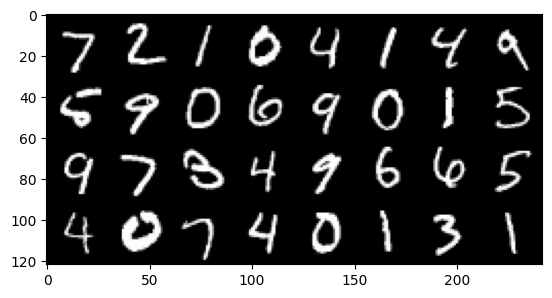

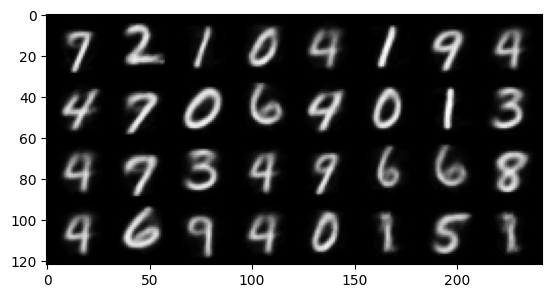

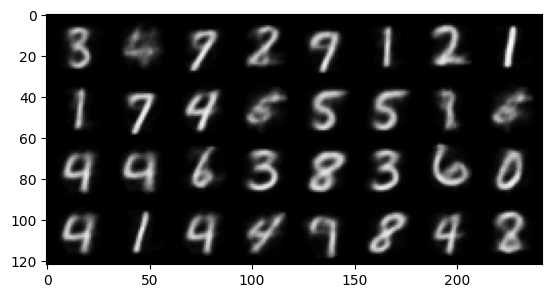

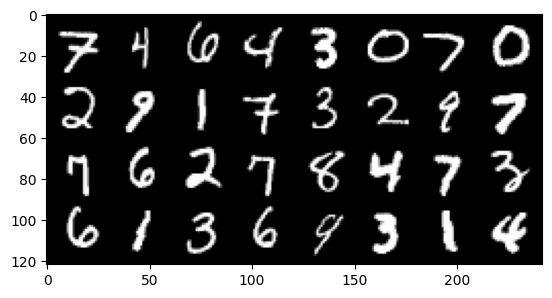

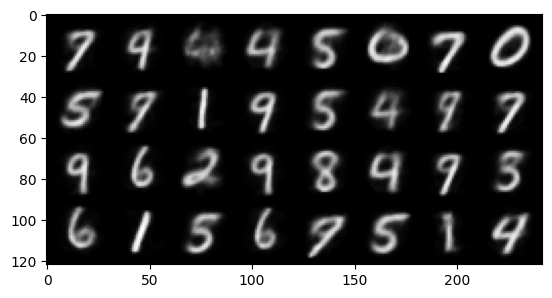

In [9]:
i = 0

auto_encoder.eval()

with torch.no_grad():
    for minibatch in test_loader:
        images, _ = minibatch
        
        if i == 3:
            break

        grid = utils.make_grid(images.cpu())
        plt.figure()
        plt.imshow(grid.permute(1, 2, 0))

        output = auto_encoder(images)

        grid = utils.make_grid(output.cpu())
        plt.figure()
        plt.imshow(grid.permute(1,2,0))
        i += 1